# **IMPORTADO DE MÓDULOS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

import tensorflow as tf
tf.version.VERSION 

2024-05-30 15:14:55.281362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 15:14:55.305847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 15:14:55.709463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [2]:
V55 = np.load('/home/josea/Co60_5cm_5cm.npy')
V28 = np.load('/home/josea/Co60_2cm_8cm.npy')
V82 = np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
from functions import gauss, gauss_fit, weights_definition, create_and_delay_pulse_pair, pulso, pulso_escalon, pulso_sigmoid, get_mean_pulse_from_set
from Models import model_definition_manual_weight_initialization

# **PREPROCESSING AND FUNCTIONS**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28, kind = 'cubic', axis = 1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55, kind = 'cubic', axis = 1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82, kind = 'cubic', axis = 1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [5]:
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING
#----------------------------- Create weights array --------------------------------------
NM = 12
weights = weights_definition(NM, int(stop - start))
print(weights.shape)

#----------------------------- Create array of all positions -----------------------------
pulsos_reales = np.concatenate((new_V28,new_V55,new_V82), axis = 0)
print(pulsos_reales.shape)

(240, 12)
(736, 4800, 2)


In [6]:
#------------------------------------- Basic definitions ----------------------------------------
Ncasos_sim = 100
Ncasos_real = int(0.3*pulsos_reales.shape[0])
Nc = 2

t = np.linspace(0,Nt,Nt_new)
#t0 = 65 + np.random.randint(5, size = Ncasos) 
t0 = 550 + np.random.randint(100, size = int(Ncasos_sim + Ncasos_real))
#t0 = 78 + np.random.randint(5, size = int(Ncasos_sim + Ncasos_real)) 

# **GENERATE MEAN PULSE PER DETECTOR**

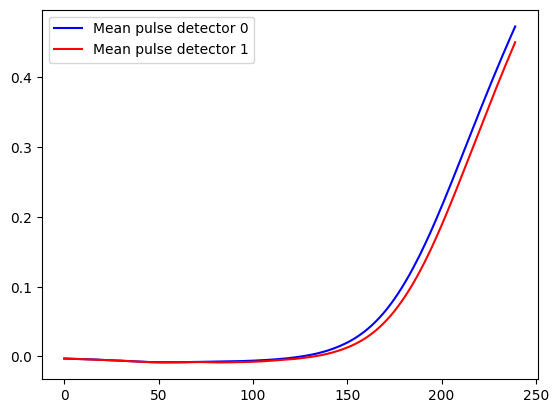

In [7]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_V55, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_V55, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **DETECTOR 0**

In [8]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 3
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

Text(0, 0.5, 'Voltage [A.U]')

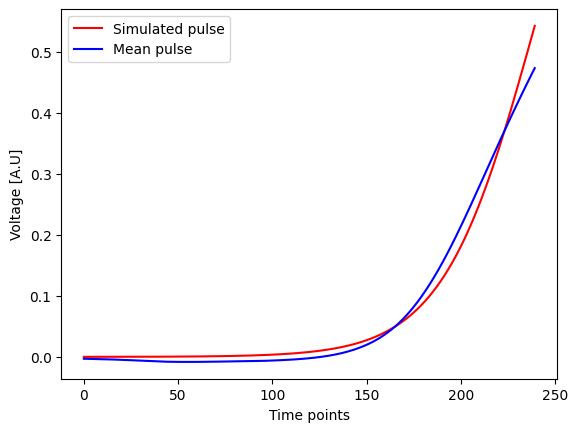

In [9]:
#pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
pulso_original_dec0 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)


plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [10]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))

for i in range(Ncasos_sim):
  centro = t0[i]
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO = pulso_escalon(t, centro, A= 0.7)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  INPUT_dec0[i,:] = PULSO

In [11]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)


#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,0], new_time_step, delay_steps = 32, NOISE = True)


#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0[:,start:stop,:], INPUT2_dec0[:,start:stop,:]), axis = 0)
REF_train_dec0 = np.concatenate((REF_dec0[:], REF2_dec0[:]))

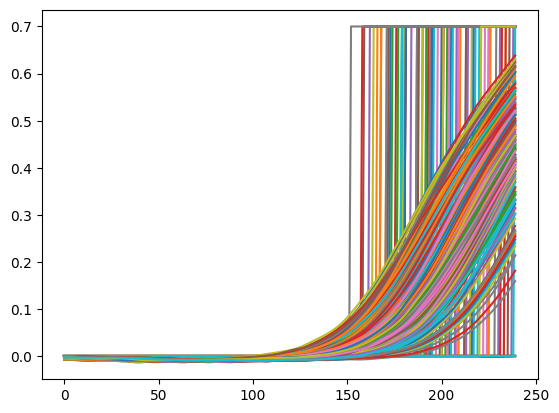

In [12]:
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])

# **DETECTOR 1**

In [13]:
#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 3
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

Text(0, 0.5, 'Voltage [A.U]')

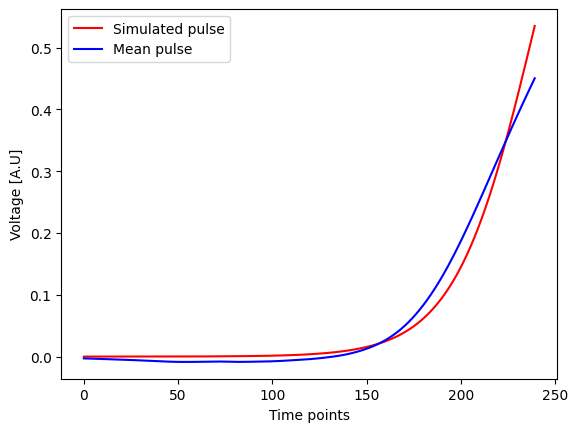

In [14]:
#pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
pulso_original_dec1 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)


plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [15]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))

for i in range(Ncasos_sim):
  
  centro = t0[i]
  #PULSO = pulso(t, centro,  tau_rise = tau_rise_dec0)
  PULSO = pulso_escalon(t, centro, A=0.7)
  #PULSO = pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec1[i,:] = PULSO

In [16]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1, new_time_step, delay_steps = 32, NOISE = True)


#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,1], new_time_step, delay_steps = 32, NOISE = True)


#--------------------------------- Create train set ----------------------------------------------------
trainX_dec1 = np.concatenate((INPUT_dec1[:,start:stop,:], INPUT2_dec1[:,start:stop,:]), axis = 0)
REF_train_dec1 = np.concatenate((REF_dec1[:], REF2_dec1[:]))

# **MULTIPLE TRAINING**

In [17]:
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)

In [47]:
epochs = 75
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):

  model_dec0 = model_definition_manual_weight_initialization(int(stop - start), weights, NM = NM, NN = 4, STD_INIT = 1.5)
  model_dec1 = model_definition_manual_weight_initialization(int(stop - start), weights, NM = NM, NN = 4, STD_INIT = 1.5)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 1e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 1e-4)

  model_dec0.compile(optimizer = opt_dec0, loss = 'MSE')
  model_dec1.compile(optimizer = opt_dec1, loss = 'MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []
  

  for epoch in range(epochs):
    
    history_dec0 = model_dec0.fit(x = [trainX_dec0[:,:,0], trainX_dec0[:,:,1]], y = REF_train_dec0, epochs = 50, batch_size = 32, shuffle = True, verbose = 0)
    history_dec1 = model_dec1.fit(x = [trainX_dec1[:,:,0], trainX_dec1[:,:,1]], y = REF_train_dec1, epochs = 50, batch_size = 32, shuffle = True, verbose = 0)

    loss_dec0.append(history_dec0.history['loss'][-1])
    loss_dec1.append(history_dec1.history['loss'][-1])

    TOFN_dec0_REF_V82 = model_dec0.predict([new_V82[:,start:stop,0], REFERENCE_PULSE_dec0[:new_V82.shape[0],:,0]])
    TOFN_dec1_REF_V82 = model_dec1.predict([new_V82[:,start:stop,1], REFERENCE_PULSE_dec1[:new_V82.shape[0],:,0]])
    TOFN_dec0_REF_V55 = model_dec0.predict([new_V55[:,start:stop,0], REFERENCE_PULSE_dec0[:new_V55.shape[0],:,0]])
    TOFN_dec1_REF_V55 = model_dec1.predict([new_V55[:,start:stop,1], REFERENCE_PULSE_dec1[:new_V55.shape[0],:,0]])
    TOFN_dec0_REF_V28 = model_dec0.predict([new_V28[:,start:stop,0], REFERENCE_PULSE_dec0[:new_V28.shape[0],:,0]])
    TOFN_dec1_REF_V28 = model_dec1.predict([new_V28[:,start:stop,1], REFERENCE_PULSE_dec1[:new_V28.shape[0],:,0]])

    TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
    TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28

    TOFN_V28_epoch.append(TOFN_V28)
    TOFN_V55_epoch.append(TOFN_V55)
    TOFN_V82_epoch.append(TOFN_V82)

    centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
    centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
    mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
    mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
    
    squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
    MEC.append(mean_error_centroid)
    MSTD.append(mean_std)

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype = 'object')
std = np.array(std, dtype = 'object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/s

(array([3]), array([74])) 0.08823655727179001


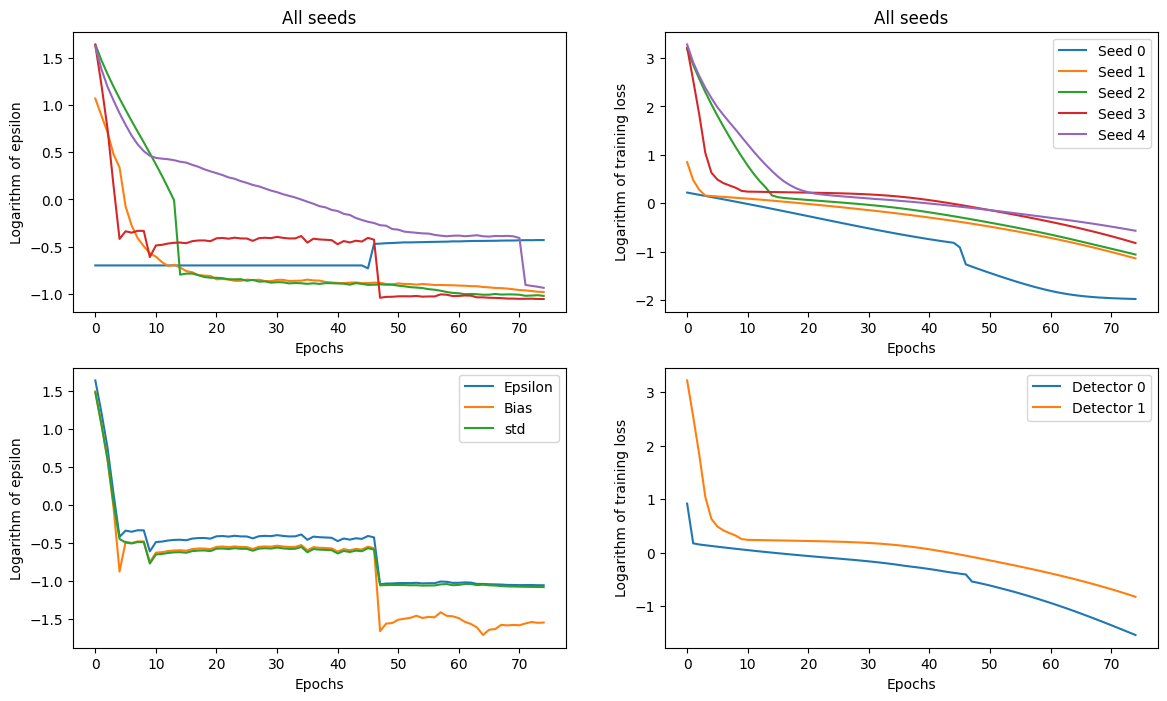

: 

In [50]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 3
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(bias[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.217  FWHM(ns) = 0.209  std(ns) = 0.089
V55: CENTROID(ns) = 0.004  FWHM(ns) = 0.167  std(ns) = 0.071
V28: CENTROID(ns) = -0.215  FWHM(ns) = 0.224  std(ns) = 0.095


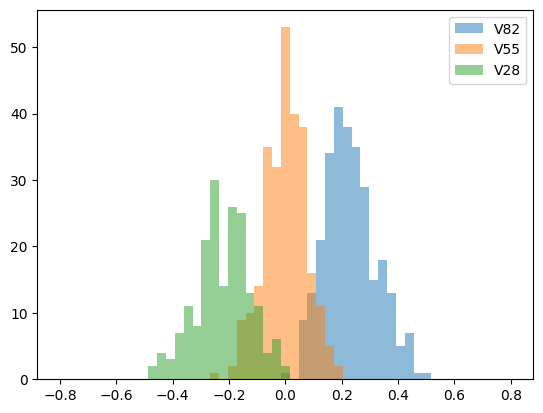

In [46]:
epoch = 43
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

(240, 12)
MSE_dec0: 0.011 MSE_dec1: 0.021


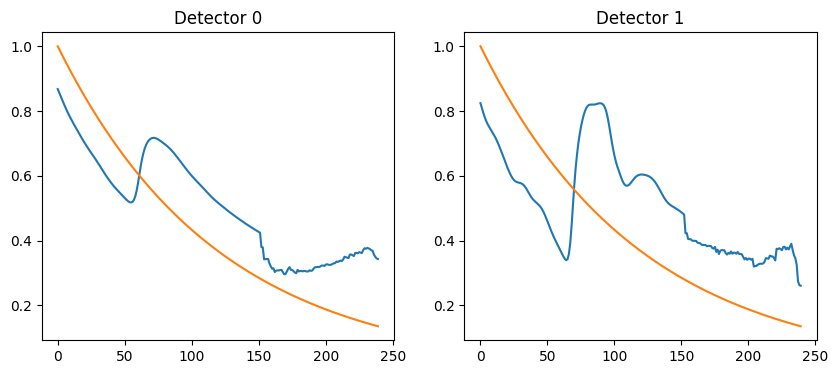

In [36]:
pesos_after_training_dec0 = np.array(model_dec0.layers[2].get_weights()[0])
pesos_after_training_dec1 = np.array(model_dec1.layers[2].get_weights()[0])
print(pesos_after_training_dec0.shape)


index = 10
plt.figure(figsize = (10,4))

plt.subplot(121)
plt.plot(pesos_after_training_dec0[:,index])
plt.plot(weights[:,index])
plt.title('Detector 0')

plt.subplot(122)
plt.plot(pesos_after_training_dec1[:,index])
plt.plot(weights[:,index])
plt.title('Detector 1');

MSE_dec0 = 0.5*np.sum((pesos_after_training_dec0[:,index] - weights[:,index])**2) / len(weights[:,index])
MSE_dec1 = 0.5*np.sum((pesos_after_training_dec1[:,index] - weights[:,index])**2) / len(weights[:,index])
print('MSE_dec0: %.3f MSE_dec1: %.3f' % (MSE_dec0,MSE_dec1))

# **ENSEMBLE MODEL**

In [22]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)


Weighted mean:
V82: CENTROID(ns) = 0.186  FWHM(ns) = 0.309  std(ns) = 0.131
V55: CENTROID(ns) = -0.015  FWHM(ns) = 0.290  std(ns) = 0.123
V28: CENTROID(ns) = -0.233  FWHM(ns) = 0.315  std(ns) = 0.134


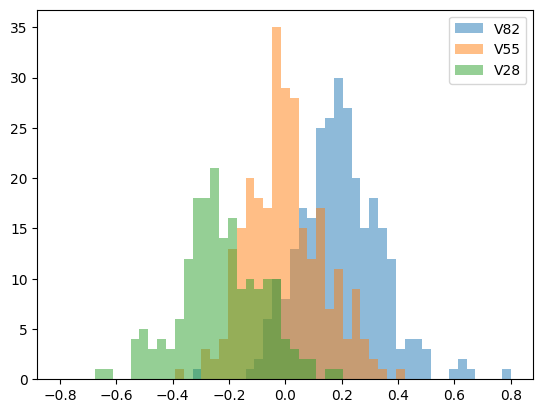

In [23]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(weighted_mean_V82 - np.mean(weighted_mean_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(weighted_mean_V55 - np.mean(weighted_mean_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(weighted_mean_V28 - np.mean(weighted_mean_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print('Weighted mean:')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))